In [1]:
import os
import json
import random
import pickle
from rdkit import Chem
import datamol as dm
import numpy as np
import tqdm
import glob
from os import path as osp
# change to where you untarred the rdkit folder


In [2]:
# base_path = "/mnt/sxtn2/chem/GEOM_data"
base_path = "/mnt/sxtn2/chem/GEOM_data/rdkit_folder"
drugs_path = "/mnt/sxtn2/chem/GEOM_data/rdkit_folder/drugs"
drugs_file = os.path.join(base_path, "summary_drugs.json")
with open(drugs_file, "r") as f:
    drugs_summ = json.load(f)

qm9_file = os.path.join(base_path, "summary_qm9.json")
with open(qm9_file, "r") as f:
    qm9_summ = json.load(f)

# data info from GeoMol
geomol_path = "/mnt/sxtn2/chem/GEOM_data/GeoMol/data/DRUGS"
train_indices, val_indices, _ = np.load(geomol_path + '/splits/split0.npy', allow_pickle=True)
train_smiles, val_smiles, _ = np.load(geomol_path + '/smiles_splits/split0.npy', allow_pickle=True)

# data info from ET-Flow
# indices_path = "/mnt/sxtn2/chem/GEOM_data/et_flow_indice/DRUGS/"
# train_indices = np.load(indices_path + "train_indices.npy", allow_pickle=True)
# val_indices = np.load(indices_path + "val_indices.npy", allow_pickle=True)
# count = np.load(indices_path + "count_indices.npy", allow_pickle=True)

In [2]:
# data info from ET-Flow
indices_path = "/mnt/sxtn2/chem/GEOM_data/et_flow_indice/DRUGS/"
train_indices = np.load(indices_path + "train_indices.npy", allow_pickle=True)
val_indices = np.load(indices_path + "val_indices.npy", allow_pickle=True)
count = np.load(indices_path + "count_indices.npy", allow_pickle=True)
len(train_indices), len(val_indices), max(max(train_indices), max(val_indices)),(len(train_indices)+len(val_indices))

(5693142, 508150, 33078482, 6201292)

In [6]:
all_files = sorted(glob.glob(osp.join(drugs_path, '*.pickle')))

In [7]:
train_files = [f for i, f in enumerate(all_files) if i in train_indices]
val_files = [f for i, f in enumerate(all_files) if i in val_indices]

In [8]:
dihedral_pattern = Chem.MolFromSmarts('[*]~[*]~[*]~[*]')

def embed_confs(mol_dic, max_confs=30):
    embedded_confs = []
    confs = mol_dic['conformers']
    random.shuffle(confs)  # shuffle confs
    name = mol_dic["smiles"]

    # filter mols rdkit can't intrinsically handle
    mol_ = Chem.MolFromSmiles(name)
    if mol_:
        canonical_smi = Chem.MolToSmiles(mol_)
    else:
        print('couldnt make smiles')
        return None

    # skip conformers with fragments
    if '.' in name:
        print('dot in string')
        return None

    # skip conformers without dihedrals
    N = confs[0]['rd_mol'].GetNumAtoms()
    if N < 4:
        print('less than 4 N')
        return None
    if confs[0]['rd_mol'].GetNumBonds() < 4:
        return None
    if not confs[0]['rd_mol'].HasSubstructMatch(dihedral_pattern):
        return None
    
    sample_mol = confs[0]["rd_mol"]
    canonical_smiles = dm.to_smiles(
            sample_mol,
            canonical=True,
            explicit_hs=True,
            with_atom_indices=False,
            isomeric=True,
        )
    smiles_with_ind = dm.to_smiles(
            sample_mol,
            canonical=True,
            explicit_hs=True,
            with_atom_indices=True,
            isomeric=True,
            )

    k = 0
    for conf in confs:
        mol = conf['rd_mol']

        # skip mols with atoms with more than 4 neighbors for now
        n_neighbors = [len(a.GetNeighbors()) for a in mol.GetAtoms()]
        if np.max(n_neighbors) > 4:
            continue

        # filter for conformers that may have reacted
        try:
            conf_canonical_smi = Chem.MolToSmiles(Chem.RemoveHs(mol))
        except Exception as e:
            continue

        if conf_canonical_smi != canonical_smi:
            continue
        

        mol, geom_id = conf["rd_mol"], conf["geom_id"]
        embedded_smiles = smiles_with_ind
        positions = mol.GetConformer().GetPositions()
        for atm_ind in range(0, len(positions)):
            x, y, z = positions[atm_ind]
            embedded_smiles = embedded_smiles.replace(f":{atm_ind}]", f"<{x:.{precision}f},{y:.{precision}f},{z:.{precision}f}>]")
        sample = {"canonical_smiles": canonical_smiles,
                "geom_id": geom_id, 
                "embedded_smiles": embedded_smiles}
        json_string = json.dumps(sample)
        embedded_confs.append(json_string)

        k += 1
        
        if k == max_confs:
            break
        
    if k == 0:
        return None
    return embedded_confs

In [10]:
def load_pkl(file_path: str):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} does not exist.")
    with open(file_path, "rb") as f:
        return pickle.load(f)

In [ ]:
data_, failed_path_ = [], []
precision = 4
conf_count_, mol_count_, fails_  = 0, 0, 0

def load_pkl(file_path: str):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} does not exist.")
    with open(file_path, "rb") as f:
        return pickle.load(f)
    
for f in tqdm.tqdm(train_files):
    try:
        mol_pickle = load_pkl(f)
        embedded = embed_confs(mol_pickle)
        mol_count_ += 1
        conf_count_ += len(embedded)
        data_.extend(embedded)
    except:
        # print(f)
        fails_+= 1
        failed_path_.append(f)

  0%|          | 998/243473 [00:58<3:59:51, 16.85it/s] [09:09:23] WARNING: not removing hydrogen atom without neighbors
[09:09:23] WARNING: not removing hydrogen atom without neighbors
[09:09:23] WARNING: not removing hydrogen atom without neighbors
[09:09:23] WARNING: not removing hydrogen atom without neighbors
[09:09:23] WARNING: not removing hydrogen atom without neighbors
[09:09:23] WARNING: not removing hydrogen atom without neighbors
[09:09:23] WARNING: not removing hydrogen atom without neighbors
[09:09:23] WARNING: not removing hydrogen atom without neighbors
[09:09:23] WARNING: not removing hydrogen atom without neighbors
[09:09:23] WARNING: not removing hydrogen atom without neighbors
[09:09:23] WARNING: not removing hydrogen atom without neighbors
[09:09:23] WARNING: not removing hydrogen atom without neighbors
[09:09:23] WARNING: not removing hydrogen atom without neighbors
[09:09:23] WARNING: not removing hydrogen atom without neighbors
[09:09:23] WARNING: not removing hy

In [16]:
data, failed_path = [], []
precision = 4
conf_count, mol_count, fails  = 0, 0, 0
    
for f in tqdm.tqdm(val_files):
    try:
        mol_pickle = load_pkl(f)
        embedded = embed_confs(mol_pickle)
        mol_count += 1
        conf_count += len(embedded)
        data.extend(embedded)
    except:
        # print(f)
        fails+= 1
        failed_path.append(f)

  1%|▏         | 383/30433 [00:13<14:59, 33.39it/s][08:52:02] WARNING: not removing hydrogen atom without neighbors
[08:52:02] WARNING: not removing hydrogen atom without neighbors
[08:52:02] WARNING: not removing hydrogen atom without neighbors
  9%|▉         | 2695/30433 [01:39<26:17, 17.58it/s]  [08:53:27] WARNING: not removing hydrogen atom without neighbors
[08:53:27] WARNING: not removing hydrogen atom without neighbors
[08:53:27] WARNING: not removing hydrogen atom without neighbors
[08:53:27] WARNING: not removing hydrogen atom without neighbors
[08:53:27] WARNING: not removing hydrogen atom without neighbors
[08:53:27] WARNING: not removing hydrogen atom without neighbors
[08:53:27] WARNING: not removing hydrogen atom without neighbors
[08:53:27] WARNING: not removing hydrogen atom without neighbors
[08:53:27] WARNING: not removing hydrogen atom without neighbors
[08:53:27] WARNING: not removing hydrogen atom without neighbors
[08:53:27] WARNING: not removing hydrogen atom wit

In [18]:
conf_count, mol_count, fails

(461583, 30433, 10107)

In [30]:
mol_dic=load_pkl('/mnt/sxtn2/chem/GEOM_data/rdkit_folder/drugs/Brc1ccc(C[NH+]2C3=NCCCN3c3ccccc32)cc1.pickle')

In [31]:
for c in mol_dic['conformers']:
    print(c)

{'geom_id': 132219380, 'set': 3, 'degeneracy': 4, 'totalenergy': -57.54024739, 'relativeenergy': 1.161, 'boltzmannweight': 0.13855, 'conformerweights': [0.03553, 0.03551, 0.03376, 0.03375], 'rd_mol': <rdkit.Chem.rdchem.Mol object at 0x7baacc9fb830>}
{'geom_id': 132219378, 'set': 1, 'degeneracy': 2, 'totalenergy': -57.54209779, 'relativeenergy': 0.0, 'boltzmannweight': 0.50341, 'conformerweights': [0.25176, 0.25165], 'rd_mol': <rdkit.Chem.rdchem.Mol object at 0x7baacc9fbdd0>}
{'geom_id': 132219379, 'set': 2, 'degeneracy': 2, 'totalenergy': -57.54168696, 'relativeenergy': 0.258, 'boltzmannweight': 0.32599, 'conformerweights': [0.163, 0.16299], 'rd_mol': <rdkit.Chem.rdchem.Mol object at 0x7baacc9fbc90>}
{'geom_id': 132219381, 'set': 4, 'degeneracy': 2, 'totalenergy': -57.53895698, 'relativeenergy': 1.971, 'boltzmannweight': 0.01813, 'conformerweights': [0.00907, 0.00906], 'rd_mol': <rdkit.Chem.rdchem.Mol object at 0x7baacc9f94e0>}
{'geom_id': 132219382, 'set': 5, 'degeneracy': 1, 'totalen

In [20]:
len(mol_dic['conformers'])

6

In [34]:
name = mol_dic["smiles"]
confs = mol_dic['conformers']
# filter mols rdkit can't intrinsically handle
mol_ = Chem.MolFromSmiles(name)
if mol_:
    canonical_smi = Chem.MolToSmiles(mol_)
else:
    print('couldnt make smiles')

# skip conformers with fragments
if '.' in name:
    print('dot in string')

# skip conformers without dihedrals
N = confs[0]['rd_mol'].GetNumAtoms()
if N < 4:
    print('less than 4 N')
if confs[0]['rd_mol'].GetNumBonds() < 4:
    print('none')
if not confs[0]['rd_mol'].HasSubstructMatch(dihedral_pattern):
    print('none')

sample_mol = confs[0]["rd_mol"]
canonical_smiles = dm.to_smiles(
        sample_mol,
        canonical=True,
        explicit_hs=True,
        with_atom_indices=False,
        isomeric=True,
    )
smiles_with_ind = dm.to_smiles(
        sample_mol,
        canonical=True,
        explicit_hs=True,
        with_atom_indices=True,
        isomeric=True,
)
for conf in confs:
    mol = conf['rd_mol']
    print(conf['geom_id'])

    # skip mols with atoms with more than 4 neighbors for now
    n_neighbors = [len(a.GetNeighbors()) for a in mol.GetAtoms()]
    if np.max(n_neighbors) > 4:
        print('1')
        continue

    # filter for conformers that may have reacted
    try:
        conf_canonical_smi = Chem.MolToSmiles(Chem.RemoveHs(mol))
    except Exception as e:
        print('2')
        continue

    if conf_canonical_smi != canonical_smi:
        print('3')
        continue
    

    mol, geom_id = conf["rd_mol"], conf["geom_id"]
    embedded_smiles = smiles_with_ind
    positions = mol.GetConformer().GetPositions()
    for atm_ind in range(0, len(positions)):
        x, y, z = positions[atm_ind]
        embedded_smiles = embedded_smiles.replace(f":{atm_ind}]", f"<{x:.{precision}f},{y:.{precision}f},{z:.{precision}f}>]")
    sample = {"canonical_smiles": canonical_smiles,
            "geom_id": geom_id, 
            "embedded_smiles": embedded_smiles}
    json_string = json.dumps(sample)
    
    print(json_string)


132219380
3
132219378
3
132219379
3
132219381
3
132219382
3
132219383
3


In [35]:
Chem.MolToSmiles(Chem.RemoveHs(mol))

'Brc1ccc(C[N@@H+]2C3=NCCCN3c3ccccc32)cc1'

In [37]:
canonical_smi

'Brc1ccc(C[NH+]2C3=NCCCN3c3ccccc32)cc1'

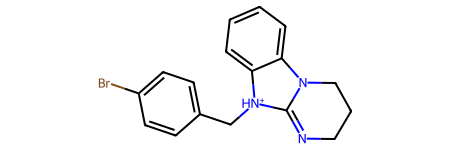

In [14]:
Chem.MolFromSmiles('Brc1ccc(C[NH+]2C3=NCCCN3c3ccccc32)cc1')

In [19]:
failed_path

['/mnt/sxtn2/chem/GEOM_data/rdkit_folder/drugs/Brc1ccc(C[NH+]2C3=NCCCN3c3ccccc32)cc1.pickle',
 '/mnt/sxtn2/chem/GEOM_data/rdkit_folder/drugs/Brc1ccc(N=C(c2ccccc2)c2ccncc2)cc1.pickle',
 '/mnt/sxtn2/chem/GEOM_data/rdkit_folder/drugs/Brc1ccc(N=C_C=C_C=C_[NH2+]c2ccc(Br)cc2)cc1.pickle',
 '/mnt/sxtn2/chem/GEOM_data/rdkit_folder/drugs/C#CC(C)(CC)NC(=O)Cn1nnc(-c2ccc(S(C)(=O)=O)cc2)n1.pickle',
 '/mnt/sxtn2/chem/GEOM_data/rdkit_folder/drugs/C#CC(CC[NH+]1CCCCC1)(OC)c1ccccc1.pickle',
 '/mnt/sxtn2/chem/GEOM_data/rdkit_folder/drugs/C#CC1(O)CCC2C3CCC4=CC(=O)CCC4C3CCC21C.pickle',
 '/mnt/sxtn2/chem/GEOM_data/rdkit_folder/drugs/C#CC1(O)CCC2C3CCc4cc(OC)ccc4C3CCC21C.pickle',
 '/mnt/sxtn2/chem/GEOM_data/rdkit_folder/drugs/C#CC1(OC(C)=O)CCC2C3CCC4=CC(=O)CCC4C3CCC21C.pickle',
 '/mnt/sxtn2/chem/GEOM_data/rdkit_folder/drugs/C#CC1C[NH+](Cc2ccccc2)CC(C#C)N1C.pickle',
 '/mnt/sxtn2/chem/GEOM_data/rdkit_folder/drugs/C#CCN1C(=O)C(O)(CC(=O)_C=C_C=C_c2ccccc2)c2ccccc21.pickle',
 '/mnt/sxtn2/chem/GEOM_data/rdkit_folder/

In [6]:
data = []
precision = 4
conf_count, mol_count  = 0, 0

def load_pkl(file_path: str):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} does not exist.")
    with open(file_path, "rb") as f:
        return pickle.load(f)

partitions = ["drugs"]
base_path = "/mnt/sxtn2/chem/GEOM_data/rdkit_folder"

for partition in partitions:
    part = json.load(open(os.path.join(base_path, f"summary_{partition}.json"), "r"))
    for en, (mol_id, mol_dict) in enumerate(tqdm.tqdm(part.items(), 
                                                      total=len(part),
                                                      desc=f"Processing molecules of {partition}")):    
        original_smiles = mol_id
        pickle_path = mol_dict.get('pickle_path', None)
        if pickle_path:
            
            
            mol_pickle = load_pkl(os.path.join(base_path, pickle_path))
            confs = mol_pickle["conformers"]
            sample_mol = confs[0]["rd_mol"]
            canonical_smiles = dm.to_smiles(
                    sample_mol,
                    canonical=True,
                    explicit_hs=True,
                    with_atom_indices=False,
                    isomeric=True,
                )
            smiles_with_ind = dm.to_smiles(
                    sample_mol,
                    canonical=True,
                    explicit_hs=True,
                    with_atom_indices=True,
                    isomeric=True,
                    )
            for conf in confs:
                mol, geom_id = conf["rd_mol"], conf["geom_id"]
                embedded_smiles = smiles_with_ind
                positions = mol.GetConformer().GetPositions()
                for atm_ind in range(0, len(positions)):
                    x, y, z = positions[atm_ind]
                    embedded_smiles = embedded_smiles.replace(f":{atm_ind}]", f"<{x:.{precision}f},{y:.{precision}f},{z:.{precision}f}>]")
                sample = {"canonical_smiles": canonical_smiles,
                        "geom_id": geom_id, 
                        "embedded_smiles": embedded_smiles}
                json_string = json.dumps(sample)
                data.append(json_string)
            mol_count += 1
            # conf_count += len(confs)
            conf_count += min(30, mol_dict.get('totalconfs',0))
        if en%10000==0:
            print(en, mol_count, conf_count)
    print(en, mol_count, conf_count)

Processing molecules of qm9: 100%|██████████| 133258/133258 [00:00<00:00, 1847354.73it/s]


0 1 1
10000 10000 137977
20000 19999 184042
30000 29999 413630
40000 39999 648336
50000 49998 867012
60000 59998 1099153
70000 69998 1279964
80000 79992 1426623
90000 89990 1547144
100000 99989 1639521
110000 109988 1710966
120000 119986 1808245
130000 129975 1885803
133257 133232 1895677


Processing molecules of drugs: 100%|██████████| 304466/304466 [00:00<00:00, 1758558.48it/s]

0 133233 1895707
10000 143229 2181784
20000 153221 2476716
30000 163220 2775894
40000 173218 3068383
50000 183218 3367801
60000 193217 3667371
70000 203216 3966028
80000 213214 4265394
90000 223208 4564000
100000 233208 4861133
110000 243207 5154542
120000 253202 5451989
130000 263200 5749578
140000 273200 6048287
150000 283200 6347576
160000 293197 6644163
170000 303191 6940031
180000 313184 7227553
190000 323182 7520409
200000 333181 7817206
210000 343180 8110526
220000 353179 8401561
230000 363177 8679254
240000 373176 8939093
250000 383154 9193884
260000 393154 9486590
270000 403154 9769142
280000 413149 10035725
290000 423140 10282931
300000 433119 10519031
304465 437580 10618229


In [141]:
conf_count

124623586

In [116]:
drugs_summ[list(drugs_summ.keys())[596]]

{'charge': 1,
 'ensembleenergy': 0.599,
 'ensembleentropy': 10.056,
 'ensemblefreeenergy': -2.998,
 'lowestenergy': -217.3338,
 'pickle_path': 'drugs/C#CCOCCOCCOCCNc1nc(N2CCN(C(=O)[C@H](CCC(=O)O)n3cc(C(N)CO)nn3)CC2)nc([NH+]2CCN(C(=O)[C@H](Cc3cc4ccccc4[nH]3)n3cc(C(N)[C@H](C)CC)nn3)CC2)n1.pickle',
 'poplowestpct': 15.657,
 'temperature': 298.15,
 'totalconfs': 846,
 'uncleaned_smiles': ['C#CCOCCOCCOCCNc1nc(N2CCN(C(=O)[C@H](CCC(=O)O)n3cc(C(N)CO)nn3)CC2)nc(N2CCN(C(=O)[C@H](Cc3cc4ccccc4[nH]3)n3cc(C(N)[C@H](C)CC)nn3)CC2)n1',
  'C#CCOCCOCCOCCNc1nc(N2CCN(C(=O)[C@H](CCC(=O)O)n3cc(C(N)CO)nn3)CC2)nc(N2CCN(C(=O)[C@H](Cc3cc4ccccc4[nH]3)n3cc(C(N)[C@H](C)CC)nn3)CC2)n1.Cl'],
 'uniqueconfs': 330}

In [125]:
len(drugs_summ.keys()), len(qm9_summ.keys()),len(drugs_summ.keys())+ len(qm9_summ.keys())

(304466, 133258, 437724)

In [14]:
geomol_path = "/mnt/sxtn2/chem/GEOM_data/GeoMol/data/DRUGS"

In [20]:
a = np.load(geomol_path + '/splits/split2.npy', allow_pickle=True)

In [21]:
len(a[0]),len(a[1]),len(a[2]),

(243473, 30433, 30433)

In [27]:
a[0][:10]

array([121714,   5664,  10919, 123841,  71733, 243322, 294175,  51627,
        14607, 220495])

In [29]:
b = np.load(geomol_path + '/smiles_splits/split3.npy', allow_pickle=True)

In [30]:
b[0][:10]

['BrC(=C\\c1ccccc1)_C=N_N1CCN(Cc2ccccc2)CC1',
 'BrC(=C\\c1ccccc1)_C=N_N1CCN(c2ccccc2)CC1',
 'BrC(=C\\c1ccccc1)_C=N_N1CCN(c2ccccn2)CC1',
 'BrC(=C\\c1ccccc1)_C=N_Nc1ccc2nncn2n1',
 'BrC(=C\\c1ccccc1)_C=N_Nc1nc(N2CCOCC2)nc(N2CCOCC2)n1',
 'BrC(=C\\c1ccccc1)_C=N_Nc1nc2ccccc2[nH]1',
 'BrC(_C=C\\c1ccccc1)=N_Nc1nc(N2CCOCC2)nc(N2CCOCC2)n1',
 'BrC(_C=N_N1CCN(Cc2ccccc2)CC1)=C_c1ccccc1',
 'BrC(_C=N_Nc1nc(N2CCOCC2)nc(N2CCOCC2)n1)=C_c1ccccc1',
 'Brc1[nH]nc2ccccc12']

In [28]:
b[0][:10]

['BrC(=C\\c1ccccc1)_C=N_N1CCN(Cc2ccccc2)CC1',
 'BrC(=C\\c1ccccc1)_C=N_N1CCN(c2ccccc2)CC1',
 'BrC(=C\\c1ccccc1)_C=N_N1CCN(c2ccccn2)CC1',
 'BrC(=C\\c1ccccc1)_C=N_Nc1ccc2nncn2n1',
 'BrC(=C\\c1ccccc1)_C=N_Nc1nc(N2CCOCC2)nc(N2CCOCC2)n1',
 'BrC(=C\\c1ccccc1)_C=N_Nc1nc2ccccc2[nH]1',
 'BrC(_C=C\\c1ccccc1)=N_Nc1nc(N2CCOCC2)nc(N2CCOCC2)n1',
 'BrC(_C=N_N1CCN(Cc2ccccc2)CC1)=C_c1ccccc1',
 'BrC(_C=N_Nc1nc(N2CCOCC2)nc(N2CCOCC2)n1)=C_c1ccccc1',
 'BrC1C(Br)C(Br)C(Br)C(Br)C1Br']

In [24]:
len(b[0]),len(b[1]),len(b[2]),

(243473, 30433, 30433)

In [78]:
canonical_smiles = dm.to_smiles(
                mol,
                canonical=True,
                explicit_hs=True,
                with_atom_indices=False,
                isomeric=True,
            )

'[Br<-3.2750,-0.9141,1.2098>][C<-2.4198,0.7760,0.5692>](=[N<-1.1825,0.8268,0.3892>]\\[N<-0.3497,-0.1854,0.5345>]([c<0.9917,-0.0793,0.2949>]1[n<1.6784,-1.1991,0.4864>][c<2.9944,-1.0828,0.2564>]([N<3.7617,-2.1625,0.4850>]2[C<3.1903,-3.4633,0.7446>]([H<2.1288,-3.3409,0.9529>])([H<3.6976,-3.8991,1.6123>])[C<3.4112,-4.3607,-0.4791>]([H<3.0968,-5.3848,-0.2728>])([H<2.8328,-3.9641,-1.3277>])[O<4.7784,-4.4302,-0.8201>][C<5.3020,-3.1526,-1.1054>]([H<6.3540,-3.3029,-1.3527>])([H<4.7806,-2.7177,-1.9722>])[C<5.1509,-2.2110,0.0961>]2([H<5.4774,-1.2033,-0.1546>])[H<5.7354,-2.5983,0.9380>])[n<3.5982,0.0392,-0.1409>][c<2.7976,1.0943,-0.3034>]([N<3.3416,2.2384,-0.7500>]2[C<4.7694,2.4286,-0.8371>]([H<5.2577,1.4631,-0.7161>])([H<5.0065,2.8501,-1.8202>])[C<5.2109,3.4087,0.2574>]([H<6.2655,3.6661,0.1474>])([H<5.0478,2.9461,1.2431>])[O<4.4986,4.6222,0.1715>][C<3.1088,4.4123,0.2985>]([H<2.6447,5.3963,0.2177>])([H<2.8836,3.9814,1.2861>])[C<2.5880,3.4700,-0.7930>]2([H<1.5357,3.2351,-0.6391>])[H<2.7343,3.9333,-

In [82]:
canonical_smiles_wi

'[Br:0][C:1](=[N:2]\\[N:3]([c:4]1[n:5][c:6]([N:24]2[C:25]([H:26])([H:37])[C:27]([H:28])([H:36])[O:29][C:30]([H:31])([H:35])[C:32]2([H:33])[H:34])[n:7][c:8]([N:10]2[C:11]([H:12])([H:23])[C:13]([H:14])([H:22])[O:15][C:16]([H:17])([H:21])[C:18]2([H:19])[H:20])[n:9]1)[H:38])/[C:39](=[C:40](\\[c:41]1[c:42]([H:51])[c:43]([H:50])[c:44]([H:49])[c:45]([H:48])[c:46]1[H:47])[H:52])[H:53]'

In [81]:

embedded_smiles = canonical_smiles_wi
positions = mols[1].GetConformer().GetPositions()
for atm_ind in range(0, len(positions)):
    x, y, z = positions[atm_ind]
    embedded_smiles = embedded_smiles.replace(f":{atm_ind}]", f"<{x:.4f},{y:.4f},{z:.4f}>]")
print(embedded_smiles)

[Br<3.0386,3.4631,-0.0669>][C<2.9689,1.4907,-0.3937>](=[N<1.8916,0.8651,-0.2976>]\[N<0.7348,1.3884,0.0493>]([c<-0.4369,0.6831,0.0266>]1[n<-1.5076,1.3914,0.3648>][c<-2.6565,0.7003,0.3305>]([N<-3.7733,1.3327,0.7291>]2[C<-3.7998,2.7559,0.9733>]([H<-2.7750,3.1216,1.0063>])([H<-4.2957,2.9352,1.9337>])[C<-4.5930,3.4415,-0.1457>]([H<-4.7335,4.5016,0.0698>])([H<-4.0485,3.3299,-1.0959>])[O<-5.8861,2.8899,-0.2653>][C<-5.8314,1.5087,-0.5419>]([H<-6.8665,1.1713,-0.6136>])([H<-5.3229,1.3375,-1.5034>])[C<-5.0843,0.7519,0.5635>]2([H<-4.9689,-0.2998,0.3075>])[H<-5.6319,0.8524,1.5072>])[n<-2.7591,-0.5779,-0.0381>][c<-1.6102,-1.1777,-0.3582>]([N<-1.6610,-2.4493,-0.7804>]2[C<-2.8854,-3.2120,-0.8038>]([H<-3.7094,-2.5548,-0.5311>])([H<-3.0372,-3.6035,-1.8167>])[C<-2.7661,-4.3837,0.1774>]([H<-3.6281,-5.0478,0.0966>])([H<-2.7005,-3.9918,1.2042>])[O<-1.6328,-5.1707,-0.1098>][C<-0.4491,-4.4070,-0.0332>]([H<0.3690,-5.0893,-0.2656>])([H<-0.3223,-4.0152,0.9871>])[C<-0.4728,-3.2336,-1.0190>]2([H<0.3994,-2.5944,-0.

In [67]:
x, y, z = positions[0]
i.replace(f":0]", f"<{x:.4f},{y:.4f},{z:.4f}>]")

'[Br<-3.2750,-0.9141,1.2098>][C:1](=[N:2]\\[N:3]([c:4]1[n:5][c:6]([N:24]2[C:25]([H:26])([H:37])[C:27]([H:28])([H:36])[O:29][C:30]([H:31])([H:35])[C:32]2([H:33])[H:34])[n:7][c:8]([N:10]2[C:11]([H:12])([H:23])[C:13]([H:14])([H:22])[O:15][C:16]([H:17])([H:21])[C:18]2([H:19])[H:20])[n:9]1)[H:38])/[C:39](=[C:40](\\[c:41]1[c:42]([H:51])[c:43]([H:50])[c:44]([H:49])[c:45]([H:48])[c:46]1[H:47])[H:52])[H:53]'

In [79]:
mols[1].GetConformer().GetPositions()[:10]


array([[ 3.03862786,  3.46312404, -0.0669465 ],
       [ 2.96885252,  1.490695  , -0.39373282],
       [ 1.89164925,  0.86512995, -0.29761305],
       [ 0.73480153,  1.38841009,  0.04931365],
       [-0.43693313,  0.68311727,  0.02655118],
       [-1.50764334,  1.39136791,  0.36480331],
       [-2.65653825,  0.70029253,  0.3304913 ],
       [-2.75911617, -0.57787937, -0.03812848],
       [-1.6101588 , -1.17765582, -0.35823303],
       [-0.40528008, -0.58833385, -0.32404014]])

In [74]:
mol.GetNumAtoms(), len(positions)

(54, 54)

In [72]:
print(Chem.MolToMolBlock(mol))


     RDKit          3D

 54 57  0  0  0  0  0  0  0  0999 V2000
   -3.2750   -0.9141    1.2098 Br  0  0  0  0  0  0  0  0  0  0  0  0
   -2.4198    0.7760    0.5692 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.1825    0.8268    0.3892 N   0  0  0  0  0  0  0  0  0  0  0  0
   -0.3497   -0.1854    0.5345 N   0  0  0  0  0  0  0  0  0  0  0  0
    0.9917   -0.0793    0.2949 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.6784   -1.1991    0.4864 N   0  0  0  0  0  0  0  0  0  0  0  0
    2.9944   -1.0828    0.2564 C   0  0  0  0  0  0  0  0  0  0  0  0
    3.5982    0.0392   -0.1409 N   0  0  0  0  0  0  0  0  0  0  0  0
    2.7976    1.0943   -0.3034 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.4732    1.0870   -0.0925 N   0  0  0  0  0  0  0  0  0  0  0  0
    3.3416    2.2384   -0.7500 N   0  0  0  0  0  0  0  0  0  0  0  0
    4.7694    2.4286   -0.8371 C   0  0  0  0  0  0  0  0  0  0  0  0
    5.2577    1.4631   -0.7161 H   0  0  0  0  0  0  0  0  0  0  0  0
    5.2109    3.4087    0

In [40]:
print(Chem.MolToSmiles(mols[0], canonical=False, isomericSmiles=False, allHsExplicit=False)  )
print(Chem.MolToSmiles(mols[0], canonical=False, isomericSmiles=False, allHsExplicit=True))

original_smiles="[H]C(C(Br)=NN([H])c1nc(N2C([H])([H])C([H])([H])OC([H])([H])C2([H])[H])nc(N2C([H])([H])C([H])([H])OC([H])([H])C2([H])[H])n1)=C([H])c1c([H])c([H])c([H])c([H])c1[H]"
print(Chem.MolToSmiles(Chem.MolFromSmiles(original_smiles), canonical=True, isomericSmiles=False, allHsExplicit=False))
original_smiles = "C(C(Br)=NNc1nc(N2CCOCC2)nc(N2CCOCC2)n1)=Cc1ccccc1"
Chem.MolToSmiles(Chem.MolFromSmiles(original_smiles), canonical=True, isomericSmiles=False, allHsExplicit=False)

BrC(=NN(c1nc(N2C([H])([H])C([H])([H])OC([H])([H])C2([H])[H])nc(N2C([H])([H])C([H])([H])OC([H])([H])C2([H])[H])n1)[H])C(=C(c1c([H])c([H])c([H])c([H])c1[H])[H])[H]
[Br][C](=[N][N]([c]1[n][c]([N]2[C]([H])([H])[C]([H])([H])[O][C]([H])([H])[C]2([H])[H])[n][c]([N]2[C]([H])([H])[C]([H])([H])[O][C]([H])([H])[C]2([H])[H])[n]1)[H])[C](=[C]([c]1[c]([H])[c]([H])[c]([H])[c]([H])[c]1[H])[H])[H]
BrC(C=Cc1ccccc1)=NNc1nc(N2CCOCC2)nc(N2CCOCC2)n1


'BrC(C=Cc1ccccc1)=NNc1nc(N2CCOCC2)nc(N2CCOCC2)n1'

In [37]:
dir(Chem.MolToSmiles())

ArgumentError: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles()
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)

In [2]:
example_smiles = list(drugs_summ.keys())[0]
print(example_smiles)
drugs_summ[example_smiles]

BrC(/C=C\c1ccccc1)=N/Nc1nc(N2CCOCC2)nc(N2CCOCC2)n1


{'charge': 0,
 'datasets': ['aid1706', 'plpro'],
 'ensembleenergy': 0.282,
 'ensembleentropy': 7.264,
 'ensemblefreeenergy': -2.166,
 'lowestenergy': -87.80248,
 'pickle_path': 'drugs/BrC(_C=C\\c1ccccc1)=N_Nc1nc(N2CCOCC2)nc(N2CCOCC2)n1.pickle',
 'poplowestpct': 46.745,
 'sars_cov_one_cl_protease_active': 0,
 'sars_cov_one_pl_protease_active': 0,
 'temperature': 298.15,
 'totalconfs': 83,
 'uniqueconfs': 27}

In [3]:
list(drugs_summ.keys()).__len__()

304466

In [4]:
mol_path = '/mnt/sxtn2/chem/GEOM_data/rdkit_folder/drugs/BrC(_C=C\\c1ccccc1)=N_Nc1nc(N2CCOCC2)nc(N2CCOCC2)n1.pickle'
with open(mol_path, "rb") as f:
        dic = pickle.load(f)

In [69]:

mol_path = '/mnt/sxtn2/chem/GEOM_data/rdkit_folder/drugs/C=CC(=O)NC(NC(=O)C=C)c1ccc(Br)cc1.pickle'
with open(mol_path, "rb") as f:
        dic = pickle.load(f)

In [71]:
dic

{'totalconfs': 125,
 'temperature': 298.15,
 'uniqueconfs': 47,
 'lowestenergy': -52.48254,
 'poplowestpct': 17.795,
 'ensembleenergy': 0.585,
 'ensembleentropy': 8.146,
 'ensemblefreeenergy': -2.429,
 'sars_cov_one_pl_protease_active': 0,
 'sars_cov_one_cl_protease_active': 0,
 'charge': 0,
 'datasets': ['aid1706', 'plpro'],
 'conformers': [{'geom_id': 119873280,
   'set': 1,
   'degeneracy': 4,
   'totalenergy': -52.48254342,
   'relativeenergy': 0.0,
   'boltzmannweight': 0.17795,
   'conformerweights': [0.04452, 0.0445, 0.04448, 0.04446],
   'rd_mol': <rdkit.Chem.rdchem.Mol at 0x7aad7ffb1990>},
  {'geom_id': 119873281,
   'set': 2,
   'degeneracy': 4,
   'totalenergy': -52.48235819,
   'relativeenergy': 0.116,
   'boltzmannweight': 0.14614,
   'conformerweights': [0.03659, 0.03659, 0.03648, 0.03648],
   'rd_mol': <rdkit.Chem.rdchem.Mol at 0x7aad7ffb1f80>},
  {'geom_id': 119873282,
   'set': 3,
   'degeneracy': 3,
   'totalenergy': -52.48212845,
   'relativeenergy': 0.26,
   'boltzm

In [82]:
dic['conformers'][0]

{'geom_id': 119873280,
 'set': 1,
 'degeneracy': 4,
 'totalenergy': -52.48254342,
 'relativeenergy': 0.0,
 'boltzmannweight': 0.17795,
 'conformerweights': [0.04452, 0.0445, 0.04448, 0.04446],
 'rd_mol': <rdkit.Chem.rdchem.Mol at 0x7aad7ffb1990>}

In [72]:
mols = [c['rd_mol'] for c in dic['conformers']]

In [77]:
smiles_ = dm.to_smiles(
            mols[0],
            canonical=False,
            explicit_hs=False,
            with_atom_indices=False,
            isomeric=True,
        )

In [78]:
smiles_

'C(=C(C(=O)N([H])C(N(C(=O)C(=C([H])[H])[H])[H])(c1c([H])c([H])c(Br)c([H])c1[H])[H])[H])([H])[H]'

In [79]:
C=CC(=O)NC(NC(=O)C=C)c1ccc(Br)cc1

SyntaxError: invalid syntax (1183683436.py, line 1)

In [39]:
def get_atomic_number_and_charge(mol: Chem.Mol):
    """Returns atoms number and charge for rdkit molecule"""
    return np.array(
        [[atom.GetAtomicNum(), atom.GetFormalCharge()] for atom in mol.GetAtoms()]
    )

pos_start_idx = 0
d = dic
confs = d["conformers"]
mols = [conf["rd_mol"] for conf in confs]

# maps the atom index to atoms in smiles string
# replicates the exact mol structure i.e.
# atom index and edge index
smiles_ = dm.to_smiles(
    mols[0],
    canonical=False,
    explicit_hs=True,
    with_atom_indices=True,
    isomeric=True,
)
smiles = [smiles_] * len(confs)

# atom specific information, positions, atomic numbers and charges
positions: np.ndarray = np.concatenate(
    [cf["rd_mol"].GetConformer().GetPositions() for cf in confs], 0
)
num_atoms, num_confs = mols[0].GetNumAtoms(), len(mols)
x: np.ndarray = np.concatenate(
    [get_atomic_number_and_charge(mol) for mol in mols]
)
pos_index_range: np.ndarray = (
    np.arange(
        pos_start_idx, pos_start_idx + num_atoms * num_confs + 1, num_atoms
    )
    .repeat(2)[1:-1]
    .reshape(-1, 2)
)

# # energy
energy = [cf["totalenergy"] for cf in confs]

dic_= dict(
    # atom based
    atomic_inputs=np.concatenate([x, positions], axis=-1, dtype=np.float32),
    pos_index_range=pos_index_range,
    num_atoms=num_atoms,
    # energy
    energy=energy,
    # string based
    smiles=smiles,
    subset='drugs',
    num_confs=num_confs,
)

In [80]:
mols[0].GetConformer().GetPositions()

array([[ 2.70643783,  4.31643295,  0.84776807],
       [ 2.67419291,  3.41448712, -0.12181641],
       [ 2.13215542,  2.05716181,  0.12160092],
       [ 1.70464969,  1.68153405,  1.1976788 ],
       [ 2.13368988,  1.24944639, -0.97391307],
       [ 2.62502265,  1.53039479, -1.80596256],
       [ 1.65898967, -0.12385449, -0.87648582],
       [ 2.38502693, -0.8377943 ,  0.14186707],
       [ 3.4473021 , -1.63378823, -0.16120808],
       [ 3.75305009, -1.89475012, -1.30855465],
       [ 4.14912891, -2.17308569,  1.02787578],
       [ 5.18715954, -2.98489308,  0.89491606],
       [ 5.71933746, -3.3907702 ,  1.73801625],
       [ 5.52777338, -3.26191688, -0.08971   ],
       [ 3.77563429, -1.86910856,  1.9954232 ],
       [ 2.23533535, -0.49581605,  1.08134007],
       [ 0.16906552, -0.16396612, -0.60489506],
       [-0.66071492,  0.85679531, -1.0505656 ],
       [-2.02105546,  0.81735075, -0.80675727],
       [-2.55192041, -0.25834915, -0.1174364 ],
       [-1.7457881 , -1.29298842,  0.323

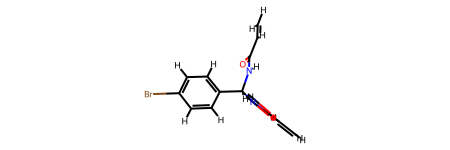

In [81]:
mols[0]

In [58]:
mols[1].GetConformer().GetPositions()

array([[ 3.03862786e+00,  3.46312404e+00, -6.69464990e-02],
       [ 2.96885252e+00,  1.49069500e+00, -3.93732816e-01],
       [ 1.89164925e+00,  8.65129948e-01, -2.97613055e-01],
       [ 7.34801531e-01,  1.38841009e+00,  4.93136458e-02],
       [-4.36933130e-01,  6.83117270e-01,  2.65511777e-02],
       [-1.50764334e+00,  1.39136791e+00,  3.64803314e-01],
       [-2.65653825e+00,  7.00292528e-01,  3.30491304e-01],
       [-2.75911617e+00, -5.77879369e-01, -3.81284840e-02],
       [-1.61015880e+00, -1.17765582e+00, -3.58233035e-01],
       [-4.05280083e-01, -5.88333845e-01, -3.24040145e-01],
       [-1.66104198e+00, -2.44931102e+00, -7.80408919e-01],
       [-2.88544941e+00, -3.21201706e+00, -8.03824604e-01],
       [-3.70939016e+00, -2.55476785e+00, -5.31084359e-01],
       [-2.76612091e+00, -4.38367033e+00,  1.77417412e-01],
       [-3.62806940e+00, -5.04780817e+00,  9.66276973e-02],
       [-1.63277102e+00, -5.17070103e+00, -1.09808803e-01],
       [-4.49085802e-01, -4.40699959e+00

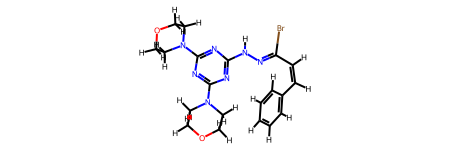

In [61]:
mols[2]

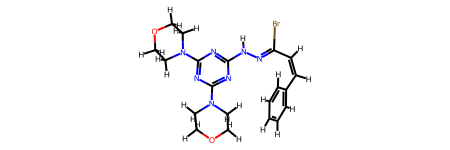

In [60]:
mols[1]

Boltzmann weight: 0.1799
Degeneracy: 6
Relative energy: 0.192


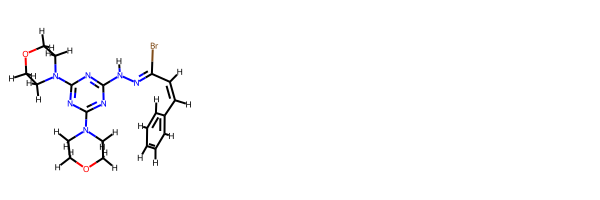

In [43]:
conf = dic['conformers'][1]
mol1 = conf['rd_mol']
weight = conf["boltzmannweight"]
degen = conf["degeneracy"]
en = conf["relativeenergy"]

print(f"Boltzmann weight: {weight}")
print(f"Degeneracy: {degen}")
print(f"Relative energy: {en}")
display(MolsToGridImage([mol1]))

Boltzmann weight: 0.19413
Degeneracy: 8
Relative energy: 0.316


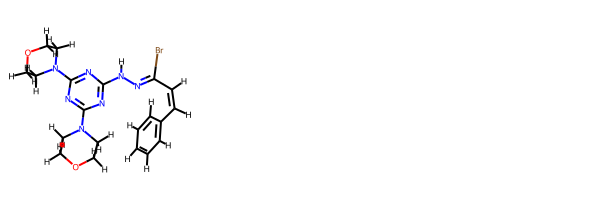

In [42]:
conf = dic['conformers'][2]
mol2 = conf['rd_mol']
weight = conf["boltzmannweight"]
degen = conf["degeneracy"]
en = conf["relativeenergy"]

print(f"Boltzmann weight: {weight}")
print(f"Degeneracy: {degen}")
print(f"Relative energy: {en}")
display(MolsToGridImage([mol2]))

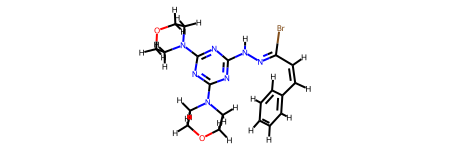

In [34]:
mol

In [45]:
view = py3Dmol.view(
    data=Chem.MolToMolBlock(mol1),  # Convert the RDKit molecule for py3Dmol
    style={"stick": {}, "sphere": {"scale": 0.3}}
)
view.zoomTo()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [44]:
import py3Dmol

view = py3Dmol.view(
    data=Chem.MolToMolBlock(mol2),  # Convert the RDKit molecule for py3Dmol
    style={"stick": {}, "sphere": {"scale": 0.3}}
)
view.zoomTo()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [41]:
print(Chem.MolToMolBlock(mol))


     RDKit          3D

 54 57  0  0  0  0  0  0  0  0999 V2000
    3.4320    3.1383   -0.2038 Br  0  0  0  0  0  0  0  0  0  0  0  0
    3.1689    1.1601   -0.3478 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.0206    0.6678   -0.3552 N   0  0  0  0  0  0  0  0  0  0  0  0
    0.8997    1.3478   -0.2395 N   0  0  0  0  0  0  0  0  0  0  0  0
   -0.3352    0.7768   -0.3820 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.4129   -0.5229   -0.5947 N   0  0  0  0  0  0  0  0  0  0  0  0
   -1.6650   -0.9780   -0.7554 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.7639   -0.2237   -0.6785 N   0  0  0  0  0  0  0  0  0  0  0  0
   -2.5551    1.0728   -0.4425 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.3461    1.6322   -0.2880 N   0  0  0  0  0  0  0  0  0  0  0  0
   -3.6244    1.8851   -0.3988 N   0  0  0  0  0  0  0  0  0  0  0  0
   -3.5220    3.2662    0.0101 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.4690    3.5399    0.0477 H   0  0  0  0  0  0  0  0  0  0  0  0
   -4.1840    3.4316    1

In [65]:
import msgpack
import os

# change to where your data is located
direc = "/mnt/sxtn2/chem/GEOM_data"

drugs_file = os.path.join(direc, "drugs_crude.msgpack")
unpacker = msgpack.Unpacker(open(drugs_file, "rb"))

In [66]:
drugs_1k = next(iter(unpacker))

In [68]:
sample_smiles = list(drugs_1k.keys())[12]
sample_sub_dic = drugs_1k[sample_smiles]
print(sample_smiles)
{key: val for key, val in sample_sub_dic.items() if key != 'conformers'}

C=CC(=O)NC(NC(=O)C=C)c1ccc(Br)cc1


{'totalconfs': 125,
 'temperature': 298.15,
 'uniqueconfs': 47,
 'lowestenergy': -52.48254,
 'poplowestpct': 17.795,
 'ensembleenergy': 0.585,
 'ensembleentropy': 8.146,
 'ensemblefreeenergy': -2.429,
 'sars_cov_one_pl_protease_active': 0,
 'sars_cov_one_cl_protease_active': 0,
 'charge': 0,
 'datasets': ['plpro', 'aid1706']}

In [84]:
sample_sub_dic["conformers"][0]['xyz']


[[6.0, 2.7064379049, 4.3164331616, 0.8477680391],
 [6.0, 2.6741929248, 3.414487033, -0.1218164153],
 [6.0, 2.1321553882, 2.0571618727, 0.1216009185],
 [8.0, 1.7046496362, 1.6815340139, 1.1976787827],
 [7.0, 2.1336899966, 1.2494463849, -0.9739130918],
 [1.0, 2.6250227007, 1.5303948235, -1.805962608],
 [6.0, 1.6589896225, -0.1238544887, -0.8764858279],
 [7.0, 2.3850269222, -0.8377942992, 0.1418670641],
 [6.0, 3.4473021619, -1.6337881932, -0.1612080856],
 [8.0, 3.7530500856, -1.8947501207, -1.3085546896],
 [6.0, 4.1491288177, -2.1730856858, 1.0278757735],
 [6.0, 5.1871593834, -2.9848930547, 0.8949160839],
 [1.0, 5.7193376386, -3.3907702644, 1.738016287],
 [1.0, 5.5277734104, -3.2619167798, -0.0897099985],
 [1.0, 3.7756342437, -1.8691085789, 1.9954232241],
 [1.0, 2.2353352752, -0.4958160534, 1.0813400672],
 [6.0, 0.1690655205, -0.163966121, -0.6048950689],
 [6.0, -0.660714922, 0.8567952868, -1.050565638],
 [6.0, -2.0210554252, 0.8173507473, -0.8067572668],
 [6.0, -2.5519204963, -0.25834916

In [17]:
mol = Chem.MolFromXYZFile(sample_sub_dic["conformers"][0]['xyz'])
# Chem.SDWriter('output.sdf')

AttributeError: module 'rdkit.Chem' has no attribute 'MolFromXYZFile'

In [20]:
from rdkit import Chem
from rdkit.Chem import AllChem

def xyz_to_mol(xyz_file):
    # Read the XYZ file
    with open(xyz_file, 'r') as f:
        lines = f.readlines()
    
    # Extract the number of atoms
    num_atoms = int(lines[0].strip())
    
    # Extract the atomic symbols and coordinates
    atoms = []
    coords = []
    for line in lines[2:2+num_atoms]:
        parts = line.strip().split()
        atom_symbol = parts[0]
        x, y, z = map(float, parts[1:4])
        atoms.append(atom_symbol)
        coords.append((x, y, z))
    
    # Create a molecule object
    mol = Chem.RWMol()
    
    # Add atoms to the molecule
    for atom_symbol in atoms:
        atom = Chem.Atom(atom_symbol)
        mol.AddAtom(atom)
    
    # Add conformer with coordinates
    conf = Chem.Conformer(num_atoms)
    for i, (x, y, z) in enumerate(coords):
        conf.SetAtomPosition(i, (x, y, z))
    mol.AddConformer(conf)
    
    # Convert to a regular Mol object
    mol = mol.GetMol()
    
    return mol

# Example usage
xyz_file = sample_sub_dic["conformers"][0]['xyz']

In [21]:
xyz_to_mol(sample_sub_dic["conformers"][0]['xyz'])

TypeError: expected str, bytes or os.PathLike object, not list

In [22]:
sample_sub_dic["conformers"][0]['xyz']

[[8.0, -3.3319635422, -2.0442902558, 0.6909756987],
 [6.0, -3.2168333749, -0.9206740514, 0.2452514931],
 [7.0, -2.0069577355, -0.3545300637, -0.0988018889],
 [6.0, -0.7379808342, -0.9107855662, -0.032150557],
 [6.0, 0.3460883674, -0.1248891969, -0.4278331255],
 [6.0, 1.6279270623, -0.629676906, -0.3872858108],
 [6.0, 1.8618600425, -1.9237381238, 0.0467393099],
 [6.0, 0.7913564976, -2.7144979703, 0.4455286077],
 [6.0, -0.4957464401, -2.2147163131, 0.4076787986],
 [1.0, -1.3270616821, -2.8278196518, 0.7150750074],
 [1.0, 0.9728504968, -3.7220742003, 0.7830047425],
 [17.0, 3.4634297054, -2.524649522, 0.0822810097],
 [16.0, 2.9835266829, 0.4198969323, -0.9208824315],
 [8.0, 3.7236332953, -0.2310199926, -1.9569565476],
 [8.0, 2.4216194889, 1.7132399647, -1.2025823471],
 [7.0, 3.9128944837, 0.4383716437, 0.4709954112],
 [6.0, 5.3520760488, 0.389959575, 0.2952279212],
 [1.0, 5.5561982774, -0.2690412476, -0.5478406962],
 [6.0, 5.9053926436, 1.7912620402, 0.0307937815],
 [8.0, 5.5317855007, 2.6

In [60]:
ind = [1,3,4,6,9]

In [63]:
l=list(range(10,23))
l

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [65]:
for i in ind:
    print(i, l[i])

1 11
3 13
4 14
6 16
9 19


In [68]:
ll=[[10,11,12],[13],[14],[15,16],[17,18],[19, 20, 21, 22]]

In [69]:
c=0
for ii in ll:
    for en, i in enumerate(ii,start=c):
        print(c, en, i)
        if en in ind:
            print(i)
        c+=1   

0 0 10
1 1 11
11
2 2 12
3 3 13
13
4 4 14
14
5 5 15
6 6 16
16
7 7 17
8 8 18
9 9 19
19
10 10 20
11 11 21
12 12 22
